In [1]:
%pylab inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from itertools import product
plt.style.use('ggplot')
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering, AffinityPropagation, KMeans
from sklearn.metrics import silhouette_samples, silhouette_score, mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pickle
import os

Populating the interactive namespace from numpy and matplotlib


Позволяет отображать крупные картинки без скроллинга:

In [1]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:2500px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

**Чтение данных**

In [3]:
raw_data = pd.read_csv('./TAXI DATA/arg_data.csv', sep = ';')
raw_data.set_index('dt', inplace=True)
raw_data.head()

,1,2,3,4,5,6,7,8,9,10,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
dt,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Подготовка данных**

На второй неделе использовались данные за май - повторим выбор столбцов (102 шт.) со средним числом поездок за май больше 5.

In [4]:
data_may = raw_data.loc['2016-05-01 00:00:00':'2016-05-31 23:00:00', :]
(data_may.mean()>5).sum()

102

In [5]:
intresting_columns = data_may.loc[:, data_may.mean()>5].columns

Сформируем итоговую обучающую выборку от 2016.01.01 00:00:00 до 2016-04-30 23:00:00

In [6]:
filtered_data = raw_data.loc[:'2016-04-30 23:00:00', raw_data.columns.str.contains('|'.join(intresting_columns))]
filtered_data.head(2)

#возможно придется поправить тут нумерацию (+1)

,1074,1075,1076,1124,1125,1126,1127,1128,1129,1130,...,1629,1683,1732,1733,1782,2067,2068,2117,2118,2167
dt,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,80.0,144.0,50.0,77.0,319.0,402.0,531.0,617.0,846.0,267.0,...,12.0,0.0,2.0,44.0,5.0,41.0,4.0,70.0,7.0,66.0
2016-01-01 01:00:00,91.0,211.0,49.0,134.0,404.0,420.0,370.0,453.0,594.0,224.0,...,29.0,0.0,5.0,2.0,2.0,4.0,0.0,47.0,1.0,29.0


Стандартизируем ряд

In [7]:
scaler = StandardScaler()
data = pd.DataFrame(scaler.fit_transform(filtered_data), 
                       columns = filtered_data.columns, index =filtered_data.index)

In [8]:
data.head()

,1074,1075,1076,1124,1125,1126,1127,1128,1129,1130,...,1629,1683,1732,1733,1782,2067,2068,2117,2118,2167
dt,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,0.534333,0.178299,-0.565388,0.271055,1.423610,0.941333,1.327688,1.324958,1.906912,1.834977,...,1.551231,-0.883705,-0.571914,-1.047780,-1.251905,-0.786766,-0.681902,-0.821275,-0.855714,0.031380
2016-01-01 01:00:00,0.823393,1.005639,-0.582598,1.673853,2.292927,1.069294,0.407607,0.529828,0.846918,1.255230,...,5.252950,-0.883705,-0.069239,-1.325716,-1.275832,-1.423829,-1.172000,-1.125258,-1.089383,-0.931147
2016-01-01 02:00:00,0.797115,0.202995,-1.030077,1.083201,2.180427,1.104839,0.081865,0.108021,-0.065856,0.095738,...,9.172418,-0.883705,-0.404356,-1.338951,-1.259881,-1.492701,-1.172000,-0.834492,-1.089383,-1.321360
2016-01-01 03:00:00,-0.727022,-0.525558,-1.150552,-0.098103,0.738384,0.920006,0.144727,-0.168335,-0.276172,0.473247,...,8.954670,-0.883705,-0.571914,-1.312481,-1.251905,-1.475483,-1.172000,-1.468890,-1.128328,-1.451432
2016-01-01 04:00:00,-0.937247,-1.068886,-1.253817,-0.319598,-0.355932,-0.110791,-0.198160,-0.051975,-0.314029,0.190115,...,8.301425,-0.883705,-0.907031,-1.332334,-1.283807,-1.492701,-1.172000,-1.402807,-1.089383,-1.529474


Переопределим тип индекса для визуализации рядов

In [9]:
data.index = pd.to_datetime(data.index)

**Кластеризация данных**

Рассмотрим следующие алгоритмы кластеризации:
* K-mean (Mini Batch K-mean)
* Affinity Propagation Clustering
* Aglomerative Clustering

Воспользуемся силуэтным анализом для выбора оптимального числа кластеров.
По мотивам:
https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

In [10]:
def plot_silhouette(method, data, n_clusters):
    res = method.fit_predict(data)
    sil = silhouette_samples(data, res)
    silhouette_avg = silhouette_score(data, res)
    y_lower = 10

    fig, ax = plt.subplots()
    fig.set_size_inches(10, 4)

    ax.set_xlim([-0.2, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(data) + (n_clusters + 1) * 10])

    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sil[res == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        spectral_color = cm.get_cmap("Spectral")
        color = spectral_color(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

        ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    plt.show()

In [11]:
def optimal_clusters_division(method, data, max_n_clusters, print_answer = False):
    score_list = []
    for n_clusters in range(2, max_n_clusters+1):
        res = method(n_clusters = n_clusters).fit_predict(data)
        score = silhouette_score(data, res)
        score_list.append(score)
    if print_answer == True:            
        print 'Максимальный коэффициент силуэта равен {}. Достигнут при числе кластеров равном {}'\
        .format(max(score_list), score_list.index(max(score_list))+2)
        return 
    return score_list   

*K-mean*

In [12]:
max_n_clusters = 10

In [13]:
optimal_clusters_division(KMeans, data.T, max_n_clusters, True)

Максимальный коэффициент силуэта равен 0.256952089379. Достигнут при числе кластеров равном 2


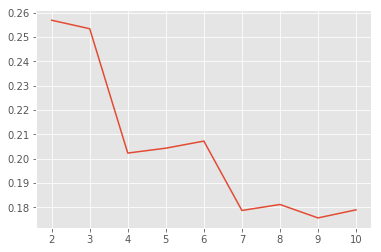

In [14]:
plt.plot(np.arange(2, max_n_clusters+1), optimal_clusters_division(KMeans, data.T, max_n_clusters))

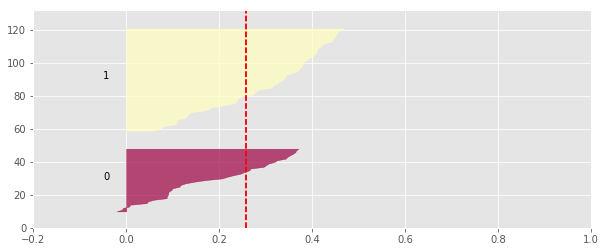

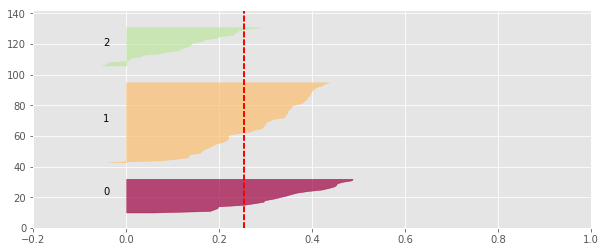

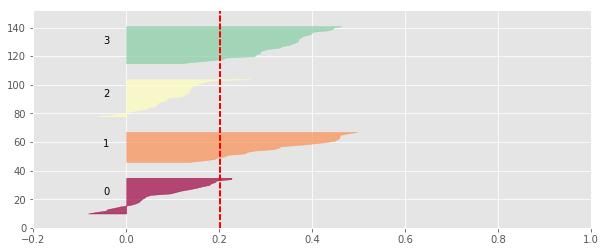

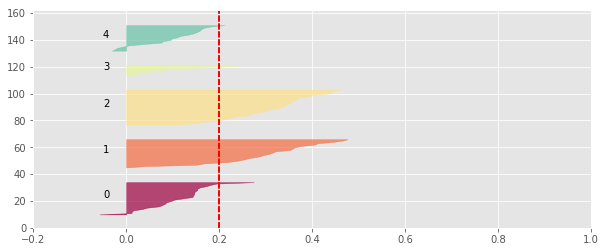

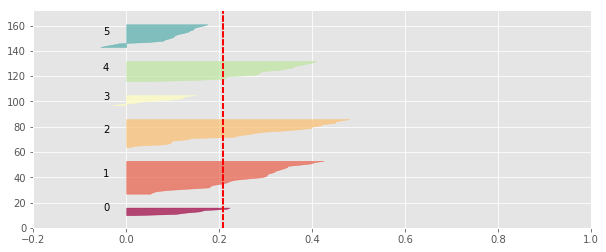

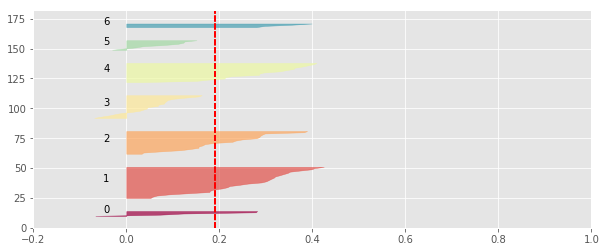

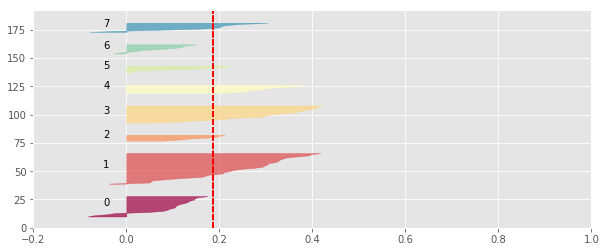

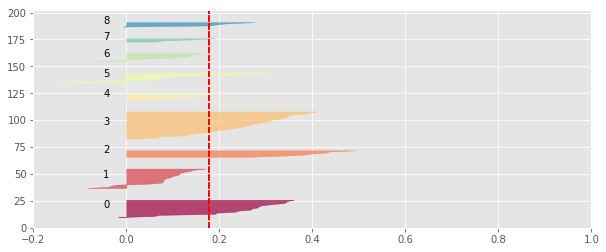

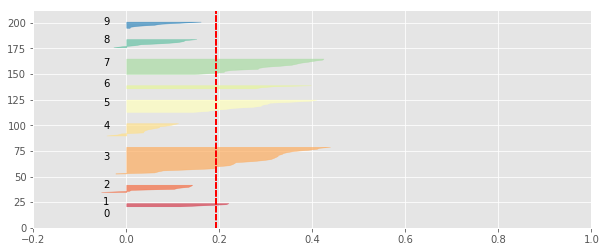

In [15]:
for n_clusters in range(2, max_n_clusters+1):
    plot_silhouette(KMeans(n_clusters=n_clusters), data.T, n_clusters)

Выводы: наиболее привлекательным выглядит разбиение на 4 или 5 кластеров. Меньшее число не выявит характерные признаки временных рядов, большее - создаст сильную неравномерность.

*Affinity Propagation Clustering*

In [16]:
score_list = []
number_of_clusters_list=[]
for damp in np.linspace(0.51, 0.99, num=9):
    clustering = AffinityPropagation(damping = damp).fit_predict(data.T)
    score = silhouette_score(data.T, clustering)
    score_list.append(score)
    n_clusters = np.unique(clustering).size
    number_of_clusters_list.append(n_clusters)
    print 'Коэффициент силуэта:{} число кластеров:{}'.format(score, n_clusters)

Коэффициент силуэта:0.185774091267 число кластеров:10
Коэффициент силуэта:0.185774091267 число кластеров:10
Коэффициент силуэта:0.185774091267 число кластеров:10
Коэффициент силуэта:0.185774091267 число кластеров:10
Коэффициент силуэта:0.185774091267 число кластеров:10
Коэффициент силуэта:0.185774091267 число кластеров:10
Коэффициент силуэта:0.185774091267 число кластеров:10
Коэффициент силуэта:0.186857718539 число кластеров:11
Коэффициент силуэта:0.214447726233 число кластеров:2


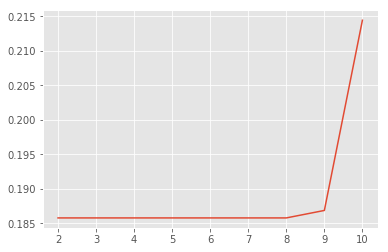

In [17]:
plt.plot(np.arange(2, max_n_clusters+1), score_list)

Рассмотрим пример распределения в случае damping = 0.6 (выбор числа обусловлен количеством кластеров в разбиении)

In [18]:
cluster_model = AffinityPropagation(damping = 0.6)
res = cluster_model.fit_predict(data.T)
np.unique(res, return_counts = True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64),
 array([ 5, 15,  9, 17, 27, 12,  4,  4,  4,  5], dtype=int64))

Выводы: качество кластеризации заметно ниже, чем в случае K-means. Наблюдается сильная неравномерность в кластерах

*Aglomerative Clustering*

In [19]:
optimal_clusters_division(AgglomerativeClustering, data.T, max_n_clusters, True)

Максимальный коэффициент силуэта равен 0.23904150647. Достигнут при числе кластеров равном 3


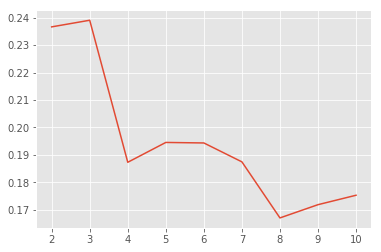

In [20]:
plt.plot(np.arange(2, max_n_clusters+1), optimal_clusters_division(AgglomerativeClustering, data.T, max_n_clusters))

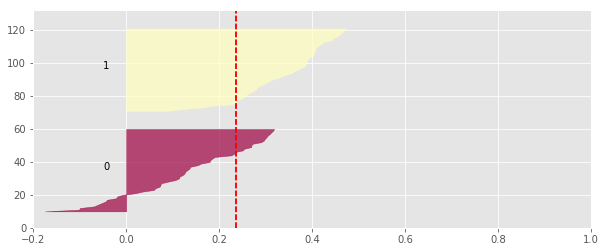

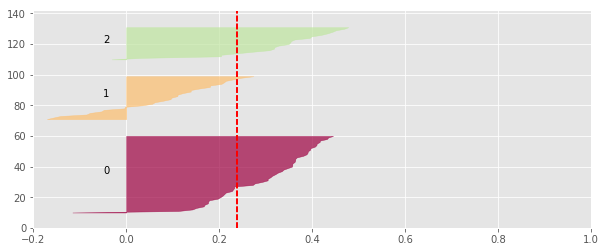

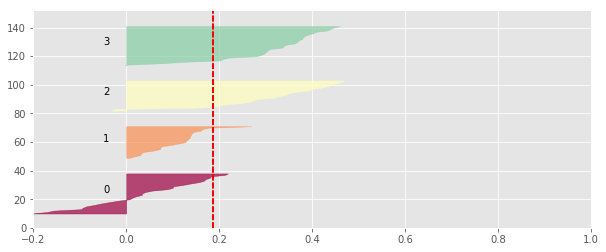

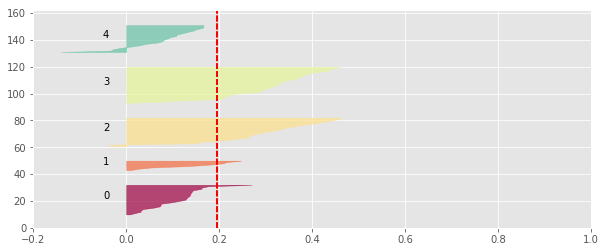

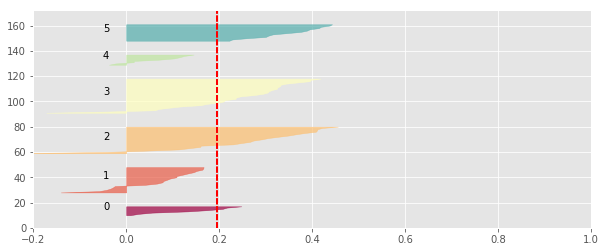

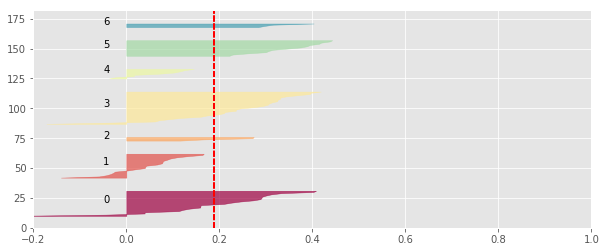

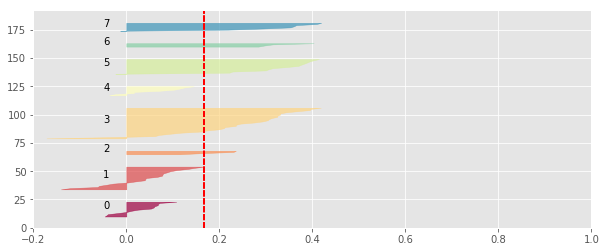

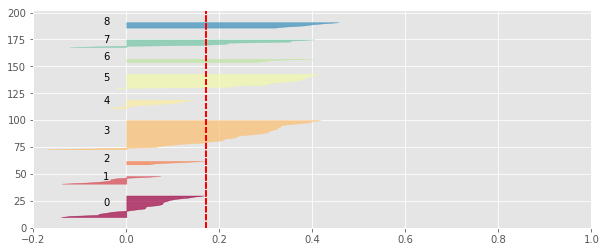

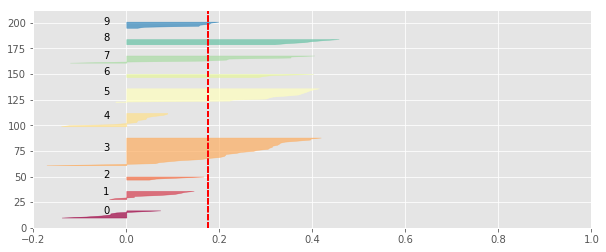

In [21]:
for n_clusters in range(2, max_n_clusters+1):
    plot_silhouette(AgglomerativeClustering(n_clusters=n_clusters), data.T, n_clusters)

Выводы: Разбиение близко к k-means, однако коэффициент силуэта немного ниже. Кроме того, в случае агломеративной кластеризации отрицательные выбросы коэффициенты больше и чаще

Выбираем кластеризацию методом K-means с разбиением на 4 кластера

In [22]:
cluster_model = KMeans(n_clusters = 4, random_state = 42)
res = cluster_model.fit_predict(data.T)
np.unique(res, return_counts = True)

(array([0, 1, 2, 3]), array([22, 27, 27, 26], dtype=int64))

In [23]:
clusters_numbers = np.unique(res)
print 'Номера кластеров: ', clusters_numbers

Номера кластеров:  [0 1 2 3]


Списки столбцов, попавшие в кластеры:

In [24]:
id_in_clusters_dict = {key: data.T[res==key].index for key in clusters_numbers}

In [25]:
for key in clusters_numbers:
    print 'id зон кластера номер', key
    print id_in_clusters_dict.get(key)

id зон кластера номер 0
Index([u'1128', u'1129', u'1175', u'1176', u'1177', u'1220', u'1221', u'1222',
       u'1226', u'1227', u'1271', u'1272', u'1273', u'1325', u'1326', u'1375',
       u'1376', u'1377', u'1379', u'1425', u'1531', u'1532'],
      dtype='object')
id зон кластера номер 1
Index([u'1075', u'1076', u'1131', u'1180', u'1182', u'1183', u'1233', u'1234',
       u'1278', u'1279', u'1282', u'1283', u'1284', u'1285', u'1286', u'1330',
       u'1331', u'1332', u'1333', u'1334', u'1335', u'1336', u'1382', u'1383',
       u'1384', u'1385', u'1433'],
      dtype='object')
id зон кластера номер 2
Index([u'1074', u'1124', u'1125', u'1126', u'1127', u'1130', u'1178', u'1179',
       u'1228', u'1229', u'1230', u'1231', u'1232', u'1280', u'1281', u'1337',
       u'1338', u'1381', u'1683', u'1732', u'1733', u'1782', u'2067', u'2068',
       u'2117', u'2118', u'2167'],
      dtype='object')
id зон кластера номер 3
Index([u'1171', u'1172', u'1173', u'1174', u'1181', u'1223', u'1224', u'12

Выведем графики временных рядов каждого кластера

In [26]:
def plot_cluster_data(length, cluster_key):
    print 'Длина выводимого ряда: {}, номер кластера: {}'.format(length, cluster_key)
    plt.figure(figsize=(20,10))
    for id in id_in_clusters_dict.get(cluster_key):
#         plt.plot(range(100), data[cur_column].iloc[-100:])
        data.loc[:, id][:length].plot()
    plt.show()

Длина выводимого ряда: 200, номер кластера: 0


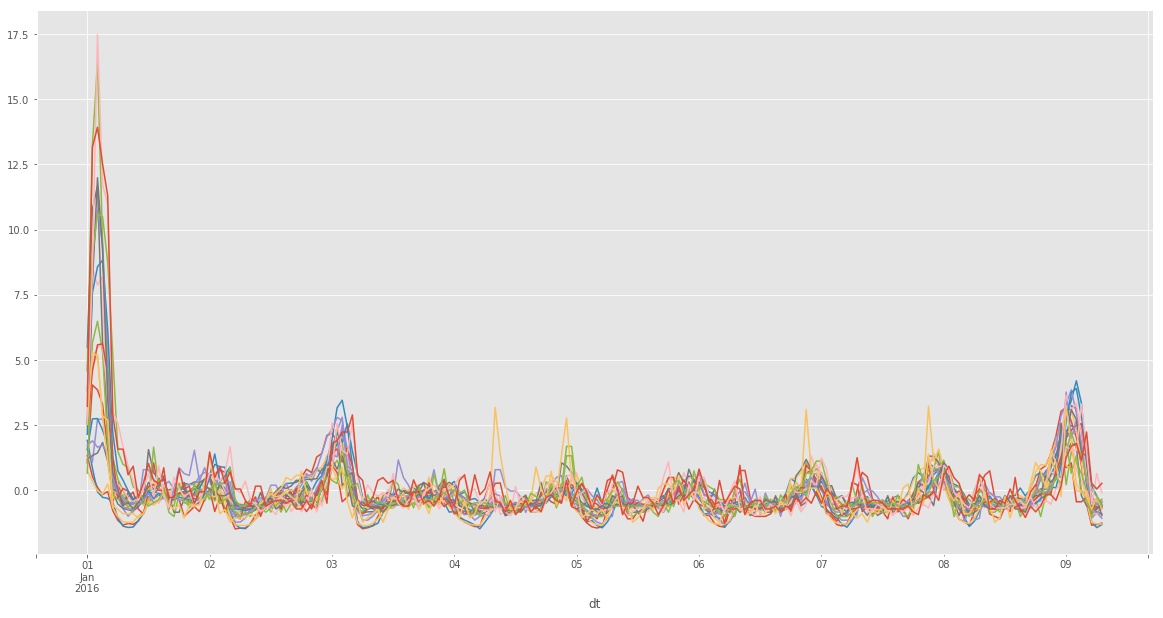

Длина выводимого ряда: 200, номер кластера: 1


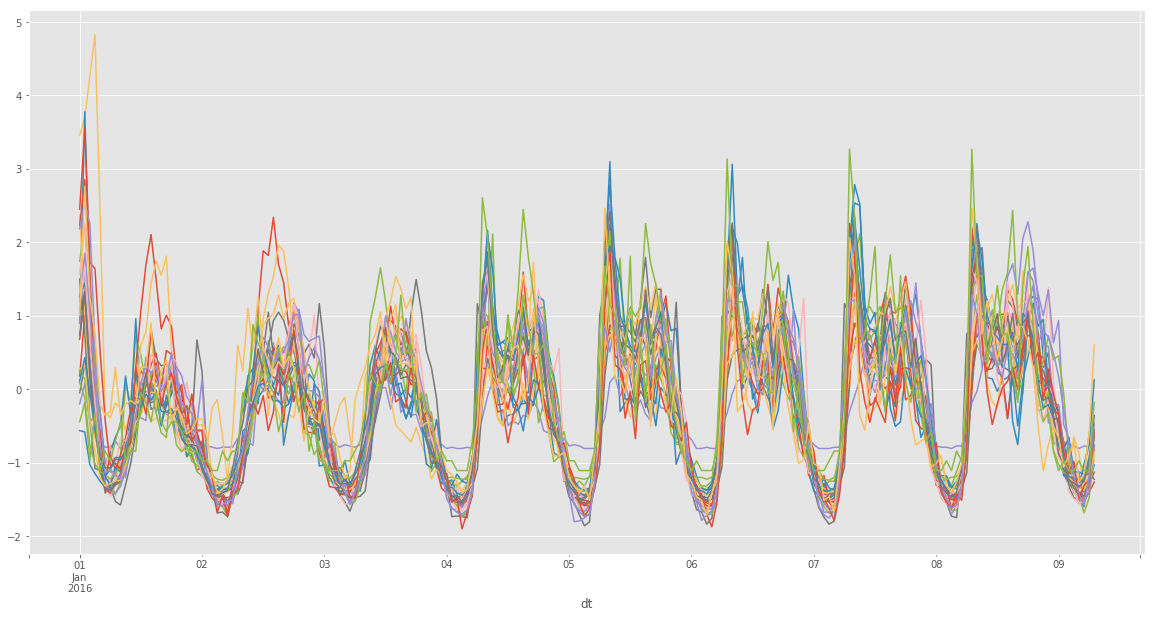

Длина выводимого ряда: 200, номер кластера: 2


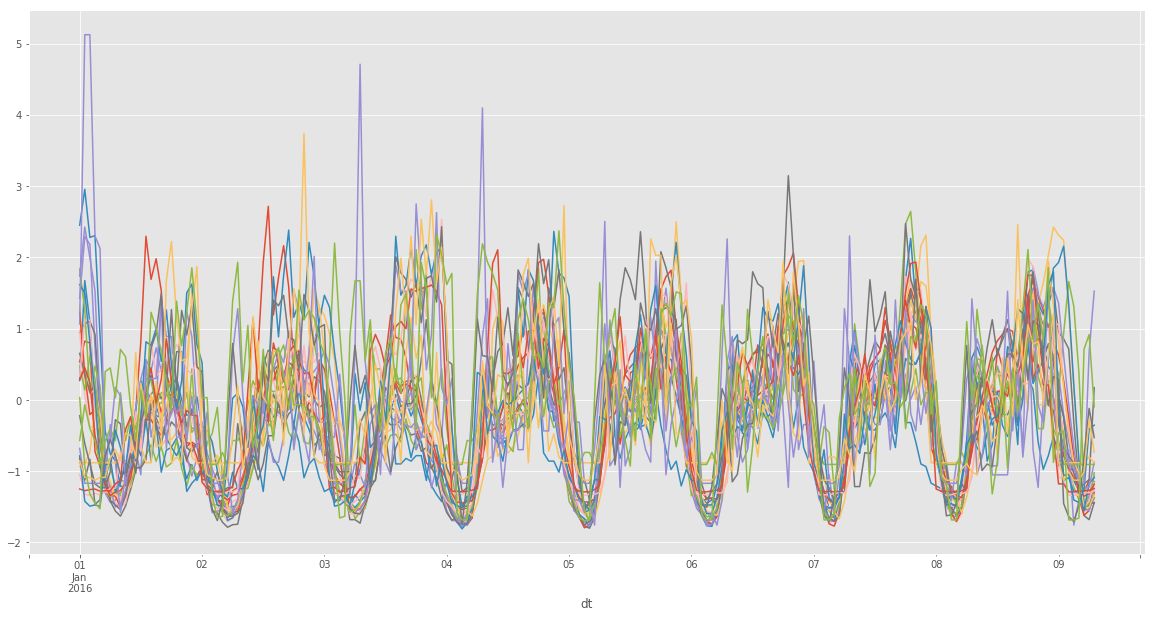

Длина выводимого ряда: 200, номер кластера: 3


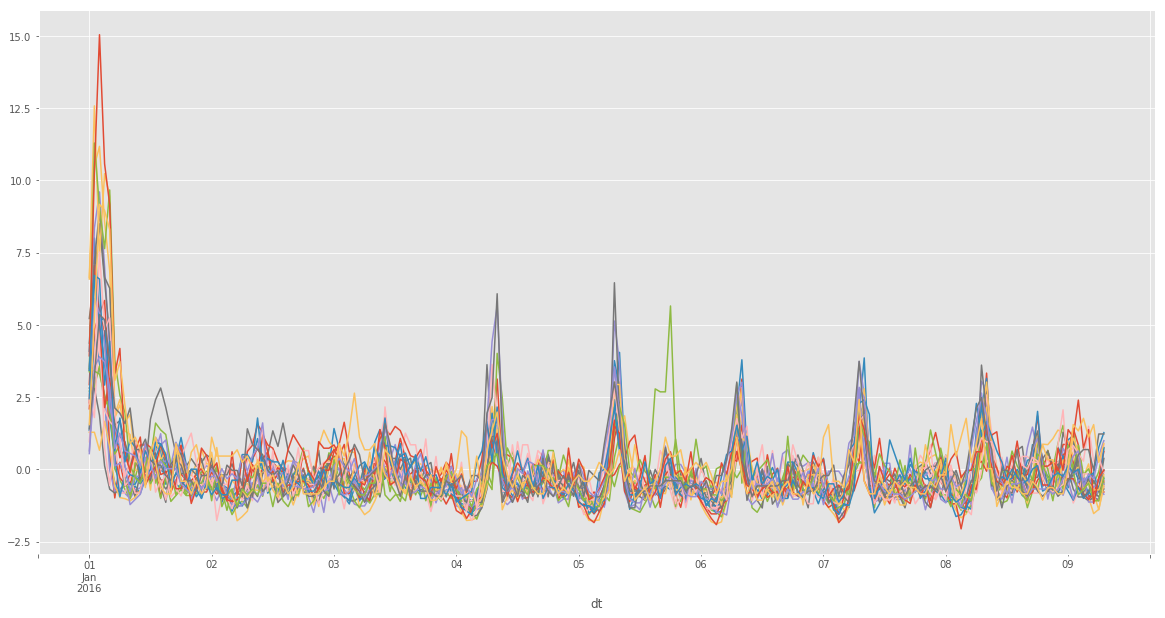

In [27]:
plot_length = 200
for key in clusters_numbers:
    plot_cluster_data(plot_length, key)


Определим центр для каждого кластера. Найдем среднее значение и наиболее коррелирующую ему строку временного ряда

In [28]:
def find_center(cluster_number):
    pearson_list = []
    cluster_mean = data.T[res == cluster_number].mean(axis = 0)
    for index, row in data.T[res == cluster_number].iterrows():
        pearson_list.append(pearsonr(cluster_mean, row)[0])
    return pearson_list.index(max(pearson_list))    

In [29]:
center_dict = {number:data.T[res == number].iloc[find_center(number), :] for number in clusters_numbers}

In [30]:
for key in clusters_numbers:
    print 'Номер кластера: {}, id центра кластера: {}'.format(key, center_dict.get(key).name)

Номер кластера: 0, id центра кластера: 1325
Номер кластера: 1, id центра кластера: 1332
Номер кластера: 2, id центра кластера: 1232
Номер кластера: 3, id центра кластера: 1386


In [31]:
id_centers_names = [center_dict.get(key).name for key in clusters_numbers]
print 'Лист с id центральных кластеров:', id_centers_names

Лист с id центральных кластеров: ['1325', '1332', '1232', '1386']


Для экономии ресуров и времени было принято решение отказаться от использования модели SARIMAX. Предсказание будет вестись в два этапа. Сначала будет построена модель прогнозов на основе регрусионных признаков от ряда Фурье. После этого по остаткам регресии будет расчитана модель SARIMA. результатом прогноза будет сумма значений двух моделей.

**Подбор параметров для линейной регрессии**

Подбор значения гиперпараметра К для линейной регресии

In [32]:
def plot_K(key, data):
    mse_list = []
    K = 25
    for number in range (1, K+1):
        ols_data = pd.DataFrame(data.copy())
        for i in range(1, number+1):        
            ols_data['s_'+str(i)] = np.sin(np.arange(1, data.shape[0]+1)*2*np.pi*i/168)
            ols_data['c_'+str(i)] = np.cos(np.arange(1, data.shape[0]+1)*2*np.pi*i/168)
        y = ols_data.iloc[:, 0]
        X = ols_data.loc[:, 's_1':]
        model = LinearRegression()
        res = model.fit(X, y)
        mse_list.append(mean_squared_error(y, res.predict(X)))
        K_opt = np.argmin(mse_list)
#     print 'Минимальное квадратичное отклонение достигнуто при K =', K_opt    
    plt.figure(figsize(10, 3))
    plt.plot(np.arange(1, K+1), mse_list, 'ro')
    plt.title(u'Зависимость между гиперпараметром K и средней квадратичной ошибкой для кластера ' + str(key))
    plt.xlabel(u'К')
    plt.ylabel(u'Mean square error')
    
    

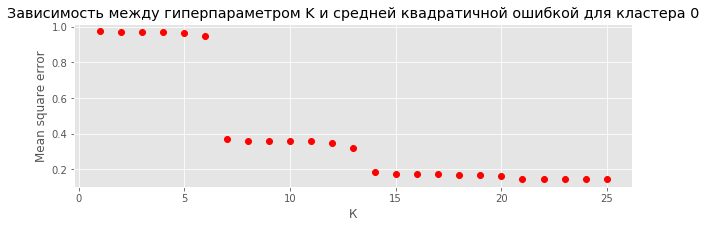

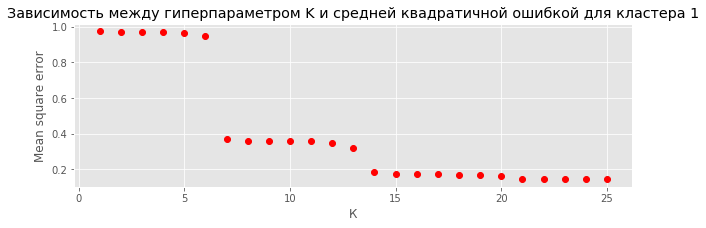

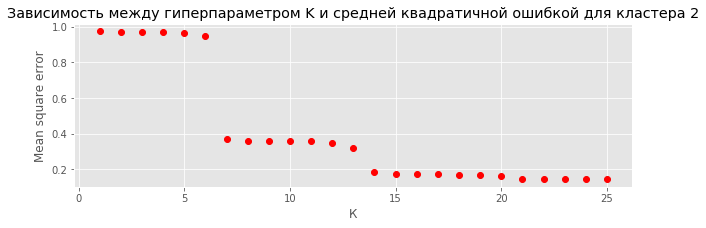

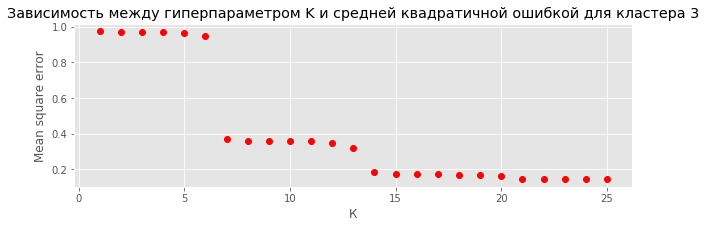

In [33]:
for key in clusters_numbers:
    plot_K(key, data['1332'])


Принимаем K_opt = 15

In [34]:
K_opt = 15

Создадим наборы признаков для каждого центрального ряда кластеров

In [35]:
def get_fourier_df_and_LR_model(key, K, df):
    '''
    Функция возвращает: 
    1) датафрейм с набором исходных значений, набором регрессионных признаков, предсказанием линейной модели,
    остаток 
    2) обученную модель линейного регрессора.
    '''
    series = pd.DataFrame.copy(df)[id_centers_names[key]]
    df_f = pd.DataFrame(series)
    for i in range(1, K+1):        
            df_f['s_'+str(i)] = np.sin(np.arange(1, len(series)+1)*2*np.pi*i/168)
            df_f['c_'+str(i)] = np.cos(np.arange(1, len(series)+1)*2*np.pi*i/168)
    y = df_f.iloc[:,0]
    X_opt = df_f.iloc[:, 1:]
    
    model = LinearRegression()
    res = model.fit(X_opt, y)
    y_pred = res.predict(X_opt)

    df_f['l_prediction'] = y_pred
    df_f['remain'] = y - y_pred 
    return df_f, res

In [36]:
fourier_and_LM_dict = {key: get_fourier_df_and_LR_model(key, K = K_opt, df = data) for key in clusters_numbers}

Пример полученного датафрейма

In [37]:
fourier_and_LM_dict.get(1)[0].head(2)

,1332,s_1,c_1,s_2,c_2,s_3,c_3,s_4,c_4,s_5,...,s_12,c_12,s_13,c_13,s_14,c_14,s_15,c_15,l_prediction,remain
dt,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,1.000432,0.037391,0.999301,0.074730,0.997204,0.111964,0.993712,0.149042,0.988831,0.185912,...,0.433884,0.900969,0.467269,0.884115,0.500000,0.866025,0.532032,0.846724,-1.067171,2.067603
2016-01-01 01:00:00,1.331004,0.074730,0.997204,0.149042,0.988831,0.222521,0.974928,0.294755,0.955573,0.365341,...,0.781831,0.623490,0.826239,0.563320,0.866025,0.500000,0.900969,0.433884,-1.405608,2.736612


**Подбор параметров для SARIMA модели**

Поработаем над остатками линейных моделей. Проведем ряд дифференциированний, рассмотрим STL декомпозицию рядов.

In [38]:
def diff_and_plot_STL_dec(key, print_STL = True):
    '''
    Функция возвращает:
    датафрейм временного ряда с добавленнием дифференцирования
    выводит STL декомпозицию при print_STL = True
    '''
    print 'Номер кластера: ', key
    df = pd.DataFrame.copy(fourier_and_LM_dict.get(key)[0])
    #недельное дифференциирование
    df['remain_diff168'] = df['remain'] - df['remain'].shift(168)
    #суточное дифференциирование
    df['remain_diff168_24'] = df['remain_diff168'] - df['remain_diff168'].shift(24)
    # стандартное дифференциирование
    df['remain_diff168_24_1'] = df['remain_diff168_24'] - df['remain_diff168_24'].shift(1)
    if print_STL:
        plt.figure(figsize(15,8))
        sm.tsa.seasonal_decompose(df['remain_diff168_24_1'][193:], freq = 24).plot()
        plt.show()
        print 'Значение критерия Дики-Фуллера для ряда:', sm.tsa.stattools.adfuller(df['remain_diff168_24_1'][193:])[1]
    return df
    

Номер кластера:  0


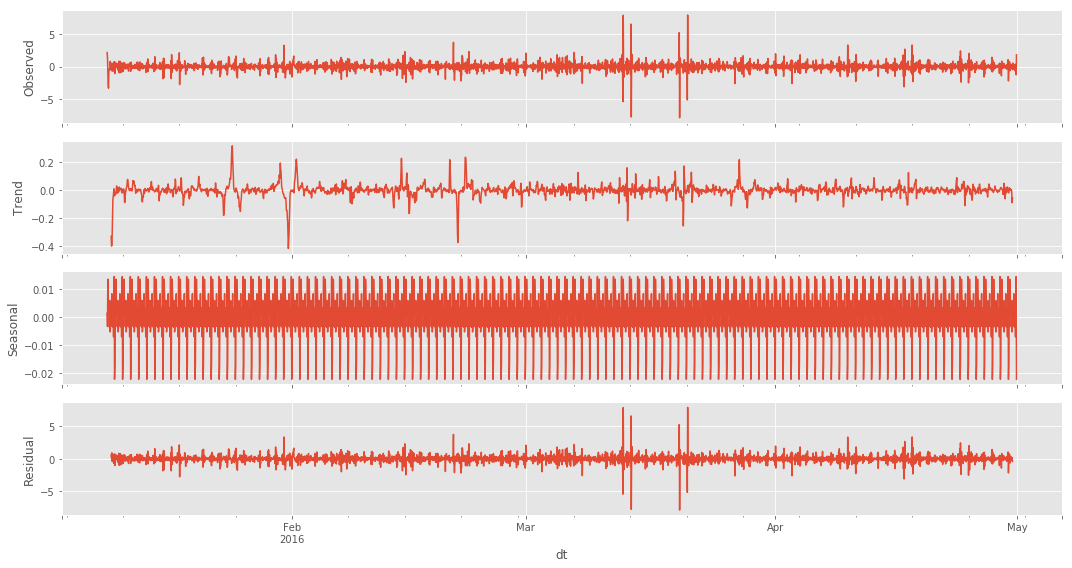

Значение критерия Дики-Фуллера для ряда: 5.698868995430292e-28
Номер кластера:  1


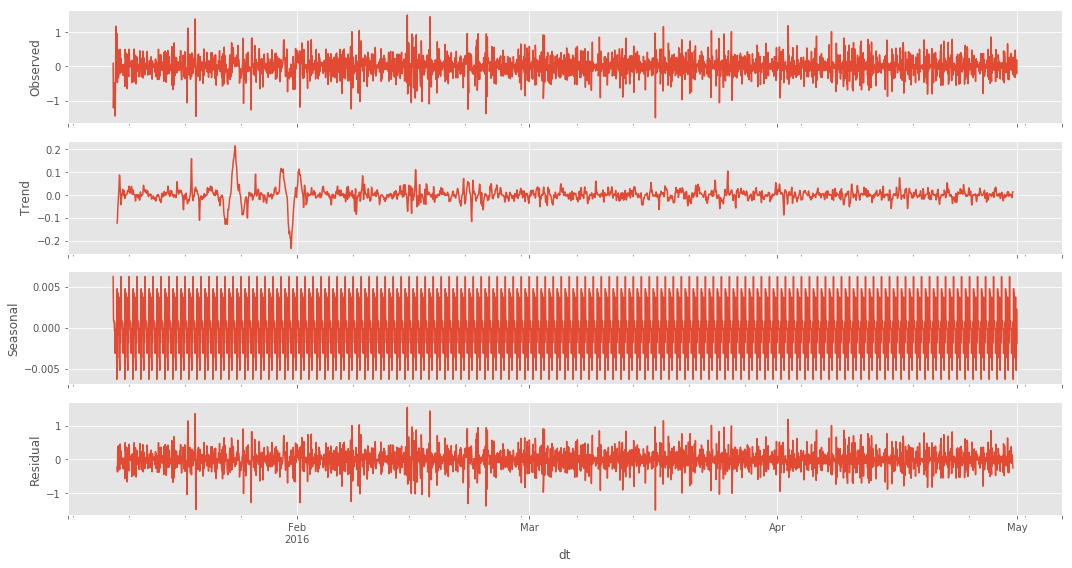

Значение критерия Дики-Фуллера для ряда: 3.0660620450327292e-28
Номер кластера:  2


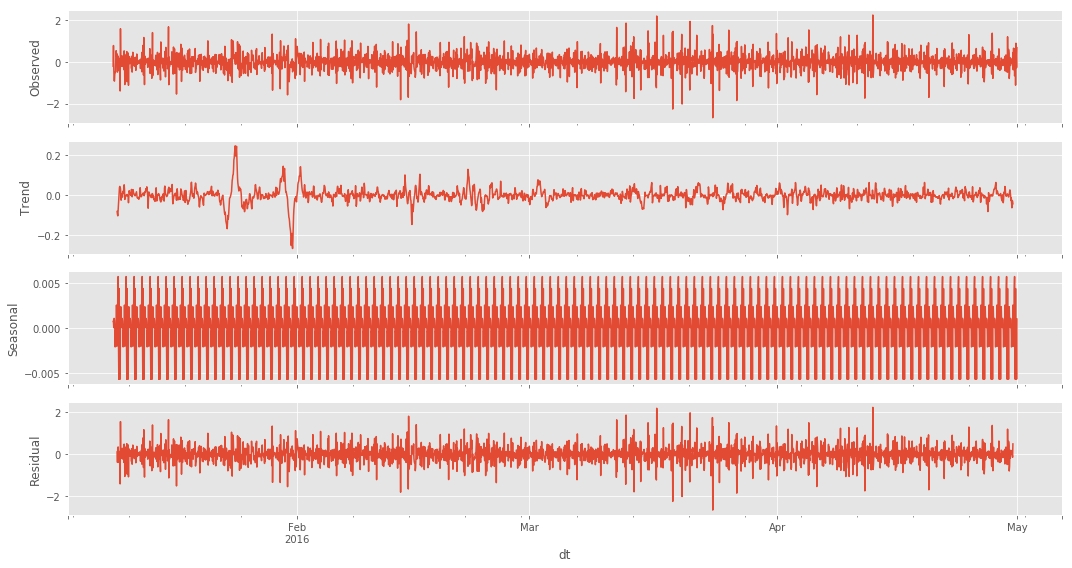

Значение критерия Дики-Фуллера для ряда: 2.4667263507636575e-28
Номер кластера:  3


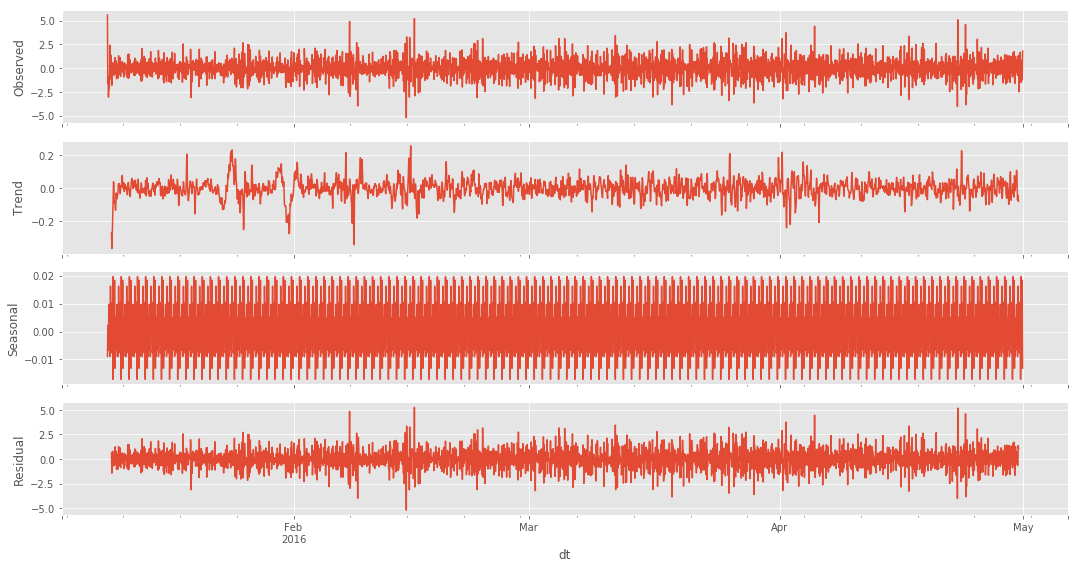

Значение критерия Дики-Фуллера для ряда: 7.597567678734874e-28


In [39]:
LR_model_and_diff_dict = {key:diff_and_plot_STL_dec(key) for key in clusters_numbers}

Значения критерия Дики - Фуллера позволяют уверенно отвергнуть гипотезу о нестационарности нашей модели. Визуальный анализ так же подтвержает это. Считаем продиференцированые ряды остатков стационарными.

Подберем коэффициенты SARIMA модели с помощью анализа графиков полной и частичной автокорреляции данных. Возьмем лаг чуть больший длины самого большого сезонного периода - недели (168).

In [40]:
def plot_autocorr_plots(key):
    print 'Номер кластера:', key
    series = LR_model_and_diff_dict.get(key)['remain_diff168_24_1'][193:]
    plt.figure(figsize(15, 10))
    ax = plt.subplot(211)
    sm.graphics.tsa.plot_acf(series, lags = 180, ax = ax)
    plt.show()
    ax = plt.subplot(212)
    sm.graphics.tsa.plot_pacf(series, lags = 180, ax = ax)
    plt.show()

Номер кластера: 0


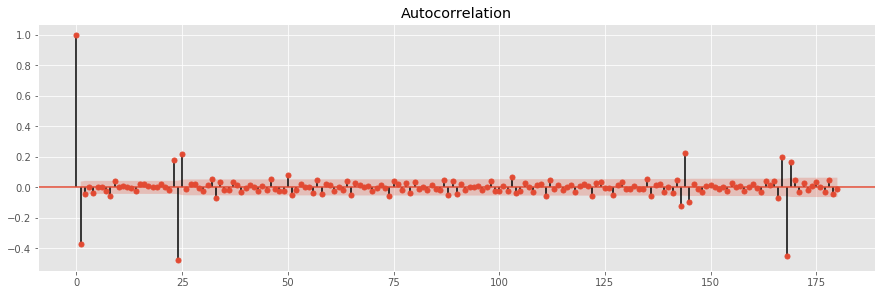

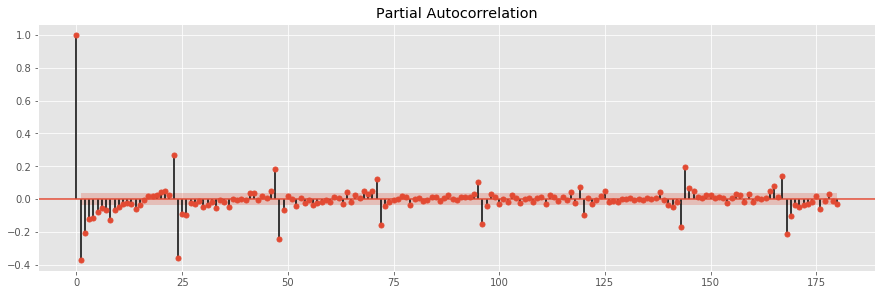

Номер кластера: 1


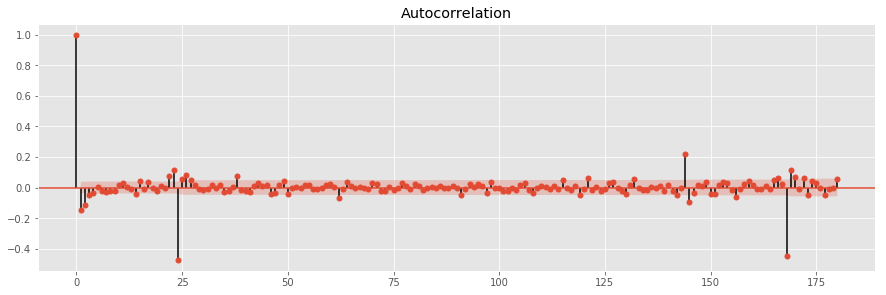

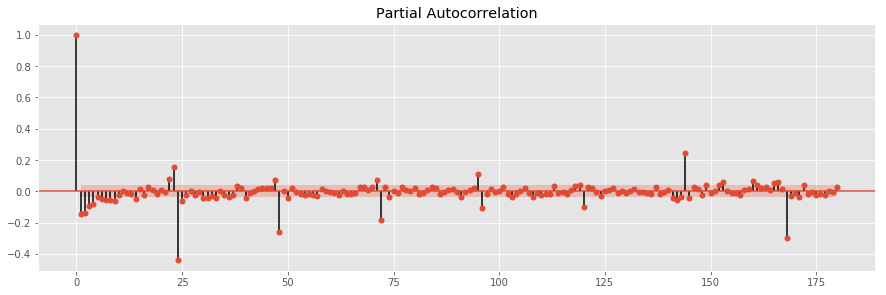

Номер кластера: 2


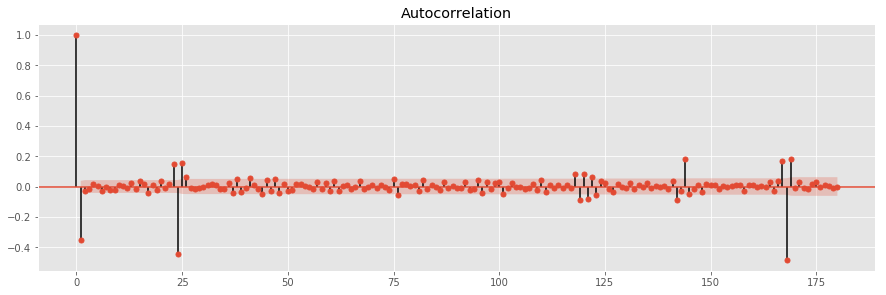

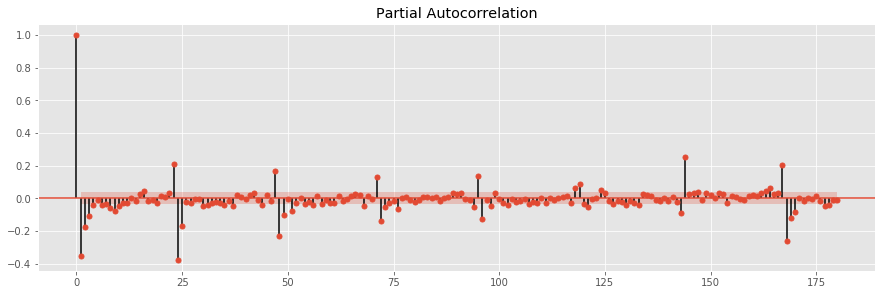

Номер кластера: 3


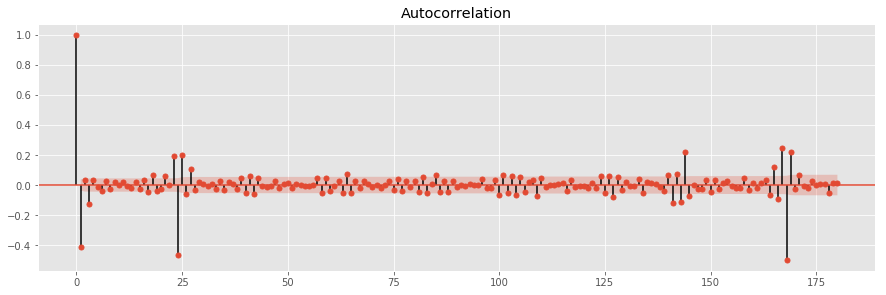

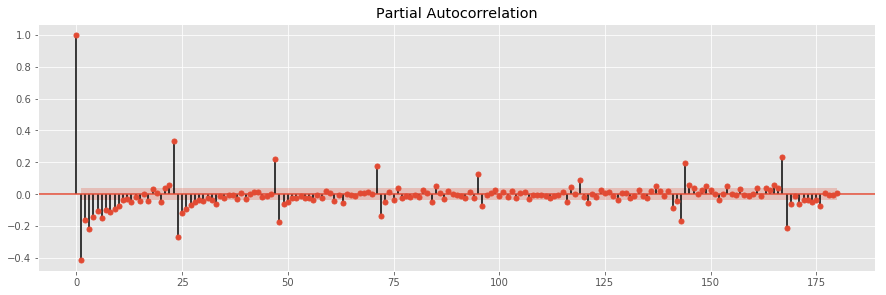

In [41]:
for key in clusters_numbers:
    plot_autocorr_plots(key)

В виду вычислительных ограничений значения параметров p, q, P, Q уменьшены

Выбранные значения параметров:
* Q = 1
* q = 2
* P = 1
* p = 2

In [42]:
ps = range(0, 3)
d = 1
qs = range(0, 3)
Ps = range(0, 2) 
D = 1 # при двойном сезонном дифференцировании резульаты были хуже, а время на вычисления удваивалось
Qs = range(0, 2)

In [43]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

**Построение SARIMA модели**

In [44]:
def build_ARIMAX(key, series):    
#     df = fourier_dict.get(key)[0]
    results = []
    best_aic = float("inf")
    warnings.filterwarnings('ignore') #отключим предупрежедения, так как не все модели, которые мы получим в процессе перебора, 
                                      #будут сходящимися
    for param in parameters_list:     
        #try except нужен, потому что на некоторых наборах параметров модель не обучается
        try:
            model=sm.tsa.statespace.SARIMAX(series, 
                                            #exog = data[data.columns[1:-2]], 
                                            order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], 24)).fit(disp=-1)
        #выводим параметры, на которых модель не обучается и переходим к следующему набору
        except ValueError:
            print('wrong parameters:', param)
            continue

        except LinAlgError:
            print('singularity parameters:', param)
            continue

        aic = model.aic
#         print 'parameters:{} have aic value {}'.format(param, aic)
        #сохраняем лучшую модель, aic, параметры
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    warnings.filterwarnings('default')
    
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    return result_table.sort_values(by = 'aic', ascending=True), best_model

In [46]:
%%time
ARIMA_dict = {key:build_ARIMAX(key, series = LR_model_and_diff_dict.get(key)['remain']) for key in clusters_numbers}

('wrong parameters:', (2, 1, 0, 0))
('wrong parameters:', (2, 1, 0, 1))
('wrong parameters:', (2, 1, 1, 0))
('wrong parameters:', (2, 1, 1, 1))
('wrong parameters:', (2, 2, 0, 0))
('wrong parameters:', (2, 2, 0, 1))
('wrong parameters:', (2, 2, 1, 0))
('wrong parameters:', (2, 2, 1, 1))
('wrong parameters:', (1, 2, 0, 0))
('wrong parameters:', (1, 2, 0, 1))
('wrong parameters:', (1, 2, 1, 0))
('wrong parameters:', (1, 2, 1, 1))
('wrong parameters:', (2, 2, 0, 0))
('wrong parameters:', (2, 2, 0, 1))
('wrong parameters:', (2, 2, 1, 0))
('wrong parameters:', (2, 2, 1, 1))
('wrong parameters:', (2, 1, 0, 0))
('wrong parameters:', (2, 1, 0, 1))
('wrong parameters:', (2, 1, 1, 0))
('wrong parameters:', (2, 1, 1, 1))
('wrong parameters:', (2, 1, 0, 0))
('wrong parameters:', (2, 1, 0, 1))
('wrong parameters:', (2, 1, 1, 0))
('wrong parameters:', (2, 1, 1, 1))
Wall time: 22min 56s


Оценим точность апроксимации модели относительно учебных данных

In [47]:
def evaluate_sarima_aproximation(key):
    arima_series = ARIMA_dict.get(key)[1].fittedvalues
    lm_series = LR_model_and_diff_dict.get(key)['l_prediction']
    forecast = arima_series + lm_series
    real_data = LR_model_and_diff_dict.get(key).iloc[:, 0]
    print 'r2_score для кластера {}: {}'.format(key, r2_score(forecast, real_data))
    
    plt.figure(figsize(20, 5))
    plt.plot(forecast[2500:3000], label = 'Linear model + SARIMA')
    plt.plot(lm_series[2500:3000], label = 'Linear model')
    plt.plot(real_data[2500:3000], label = 'Real data', color = 'green', alpha = 0.5)
    
    plt.legend()
    plt.show()    

r2_score для кластера 0: 0.839146585121


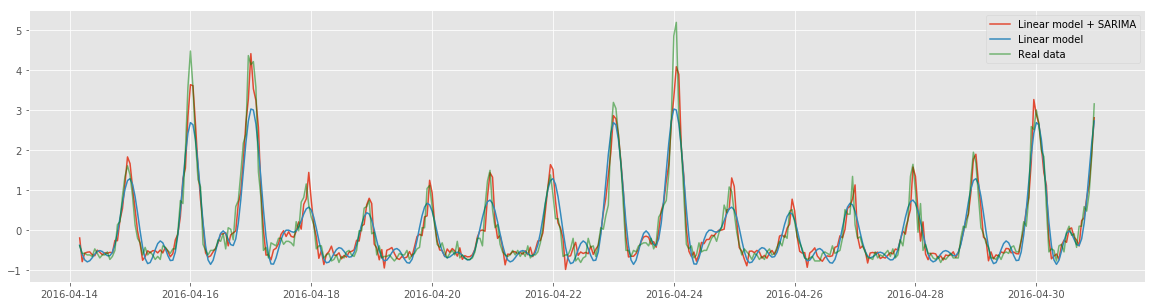

r2_score для кластера 1: 0.943351987479


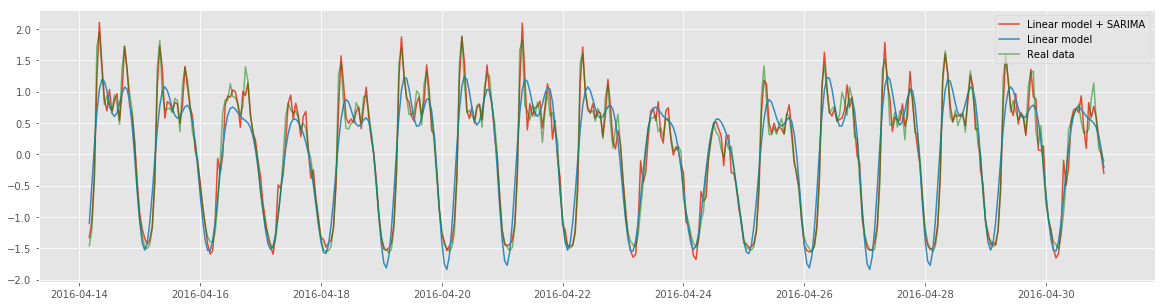

r2_score для кластера 2: 0.930497552042


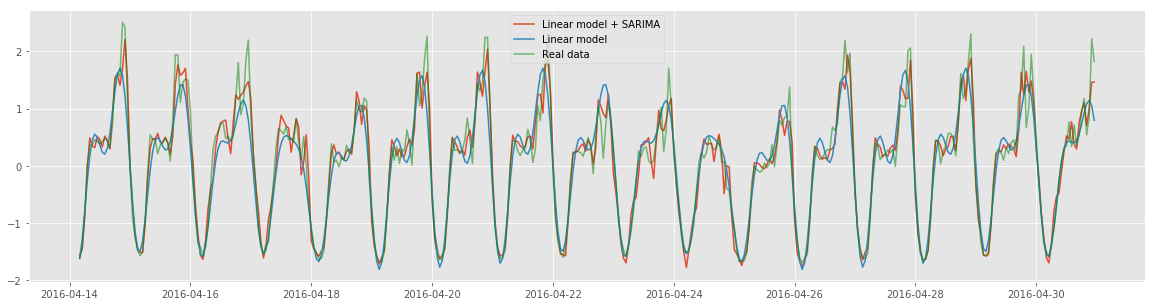

r2_score для кластера 3: 0.57615457638


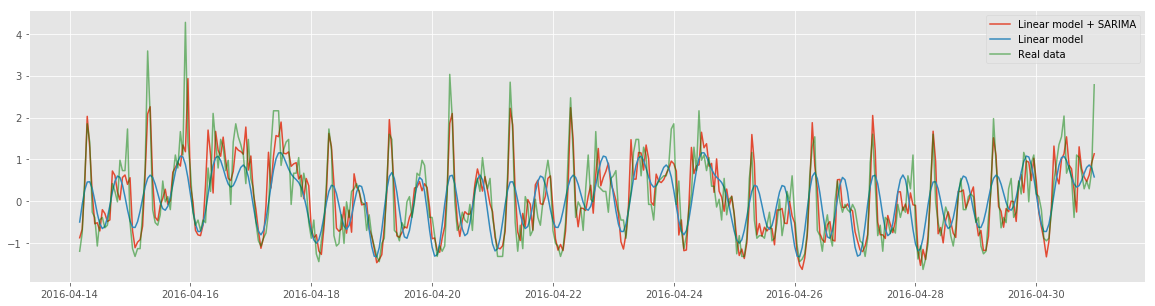

In [48]:
for key in clusters_numbers:
    evaluate_sarima_aproximation(key)

Визуальная оценка вкупе с коэффициентом детерминации дают приемлимые результаты.
Далее будем использовать наборы оптимальных параметров для обучения и прогнозирования LR и SARIMA моделей на реальных данных

Наборы оптимальных параметров для SARIMA 

In [49]:
best_ARIMA_params_list = []
for key in clusters_numbers:
    best_ARIMA_params_list.append(ARIMA_dict.get(key)[0].iloc[0].values[0])
print best_ARIMA_params_list

[(1, 2, 1, 1), (2, 1, 1, 1), (2, 2, 1, 1), (2, 2, 1, 1)]


**Прогнозирование времнных рядов**

**Прогнозирование в интервале от 2016.04.30 23:00 до 2016.05.31 17:00 на 6 часов вперед**

Подход к прогнозированию линейных признаков взят тут: https://habr.com/ru/company/ods/blog/327242/

Подход к прогнозированию SARIMA брал здесь: https://inclass.kaggle.com/c/yellowtaxi/discussion/27157

In [49]:
data_may = raw_data.loc[:'2016-05-31 23:00:00']

Определим необходимые функции для прогнозирования с помощью линейной регресии, проверим их работоспособность на примере центра нулевого кластера

In [50]:
def code_mean(data, cat_feature, real_feature):
    """
    Возвращает словарь, где ключами являются уникальные категории признака cat_feature, 
    а значениями - средние по real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

In [51]:
def prepare_data(key, id_number, data, split_date, K):
    data =data.copy()[str(id_number)].to_frame()
    data.columns = ['y']
    data.index = pd.to_datetime(data.index)
    
    split_number = len(data.loc[:split_date, :])
    
    
    # добавляем набор регрессионных признаков Фурье
    for i in range(1, K+1):        
            data['s_'+str(i)] = np.sin(np.arange(1, data.shape[0]+1)*2*np.pi*i/168)
            data['c_'+str(i)] = np.cos(np.arange(1, data.shape[0]+1)*2*np.pi*i/168)
    data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1
    
    # считаем средние только по тренировочной части, чтобы избежать лика
    data['weekday_average'] = map(code_mean(data[:split_number], 'weekday', "y").get, data.weekday)
    data["hour_average"] = map(code_mean(data[:split_number], 'hour', "y").get, data.hour)
    
    # выкидываем закодированные средними признаки 
    data.drop(["hour", "weekday"], axis=1, inplace=True)

    data = data.dropna()
    data = data.reset_index(drop=True)
    
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:split_number].drop(["y"], axis=1)
    y_train = data.loc[:split_number]["y"]
    X_test = data.loc[split_number:].drop(["y"], axis=1)
    y_test = data.loc[split_number:]["y"]

    return X_train, X_test, y_train, y_test

    


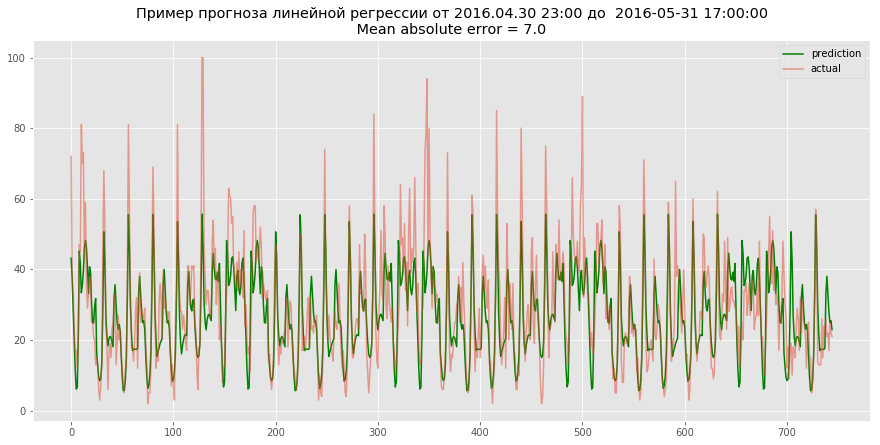

In [52]:
X_train, X_test, y_train, y_test = prepare_data(key = 0, id_number = 1386, data = data_may, 
                                                split_date = '2016-04-30 22:00:00', K = K_opt)
lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)
plt.figure(figsize=(15, 7))
plt.plot(prediction, "g", label="prediction")
plt.plot(y_test.values, label="actual", alpha = 0.5)
plt.legend(loc="best")
plt.title(u"Пример прогноза линейной регрессии от 2016.04.30 23:00 до  2016-05-31 17:00:00\n Mean absolute error = {} "\
          .format(round(mean_absolute_error(prediction, y_test))))
plt.grid(True);


Визуальный анализ и метрика подтверждает правильность работы функции.

Подготовим остатки линейной регресии для каждого ряда и обучим для него SARIMA модель. Если SARIMA модель не запуститься, то применяем ARMA модель.

In [53]:
best_ARIMA_params_list

[(1, 2, 1, 1), (2, 1, 1, 1), (2, 2, 1, 1), (2, 2, 1, 1)]

Подготовим SARIMA (ARMA) модели для каждого из 102 регионов

In [52]:
def createFolder(directory): # В итоге функция не пригодилась - проще сделать папку руками
    '''
    Функция создает пустую папку в заданной директории
    '''
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)

In [53]:
def generate_SARIMA_models(key, id_number, data, split_date, folder_name, K):
    X_train, _, y_train, _ = prepare_data(key = key, id_number = id_number, data = data, 
                                                    split_date = split_date, K = K)
    # Подгтовка LR модели для каждого ряда
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    remains = lr.predict(X_train) - y_train
    
    try:
        # Пробуем SARIMA модель 
        param = best_ARIMA_params_list[key]
        model=sm.tsa.statespace.SARIMAX(remains, 
                                            #exog = data[data.columns[1:-2]], 
                                            order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], 24)).fit(disp=-1)         
        model.save('./TAXI DATA/SARIMA models/' + str(folder_name)+ '/SARIMA model ' + str(id_number) + '.pkl')
        del model
        print id_number,            

    except:
        print
        print 'Ошибка при построении SARIMA модели'

        try:
            # Пробуем ARMA модель
            model=sm.tsa.statespace.SARIMAX(remains, 
                                            #exog = data[data.columns[1:-2]], 
                                            order=(1, 0, 1), 
                                            seasonal_order=(1, 0, 0, 24)).fit(disp=-1)
            model.save('./TAXI DATA/SARIMA models/' + str(folder_name)+ '/SARIMA model ' + str(id_number) + '.pkl')
            del model
            print id_number,

        except:
            print
            print 'Ошибка при построении ARMA модели'
            print 'Проблемный ряд:', id_number                            

In [ ]:
# %%time
# for key in clusters_numbers:
#     print
#     print key
#     for id_number in id_in_clusters_dict.get(key):
#         generate_SARIMA_models(key, id_number, data = data_may, 
#                                split_date = '2016-04-30 22:00:00', folder_name = 'may', K = K_opt)

Спрогнозируем данные

In [56]:
Q_may = 0
for key in clusters_numbers:
    print key
    for id_number in id_in_clusters_dict.get(key):
        print id_number,

        X_train, X_test, y_train, y_test = prepare_data(key = key, id_number = id_number, data = data_may, 
                                                split_date = '2016-04-30 22:00:00', K = K_opt)

        # Подгтовка LR модели для каждого ряда
        lr = LinearRegression()
        lr.fit(X_train, y_train)         

        # Загрузка подготовленной ARIMA модели
        with open ('./TAXI DATA/SARIMA models/may/SARIMA model '+str(id_number) +'.pkl', 'rb') as arima:
            model_res = pickle.load(arima)

        # Предскажем остатки линейной регрессии до конца мая для второй модели
        remains_train = lr.predict(X_train) - y_train
        remains_test = lr.predict(X_test) - y_test
        remains_full = np.append(remains_train, remains_test)

        #         lr_remains = LinearRegression()
        #         lr_remains.fit(X_train, remains_train)
        #         remains_predicted = lr_remains.predict(X_test)

        #Выбираем какую ARIMA модель выбрать номером два (SARIMA или ARMA)
        statinfo = os.stat('./TAXI DATA/SARIMA models/may/SARIMA model '+str(id_number) +'.pkl')
        file_size = statinfo.st_size

        if file_size > 160000000: #Размер файла с ARMA моделью равен 154604036

            # Создаем  модель SARIMA на весь временной интервал выборки
            try:
                param = best_ARIMA_params_list[key]
#                 print param
                model_fitted = sm.tsa.statespace.SARIMAX(remains_full, 
                                                        #exog = data[data.columns[1:-2]], 
                                                        order=(param[0], d, param[1]), 
                                                        seasonal_order=(0, D, param[3], 24)).filter(model_res.params)

            except: # Иногда уже отлаженные на SARIMAX модели вылетали с ошибкой
                model_fitted = sm.tsa.statespace.SARIMAX(remains_full, 
                                                        #exog = data[data.columns[1:-2]], 
                                                        order=(1, 0, 1), 
                                                        seasonal_order=(1, 0, 0, 24)).filter(model_res.params)
        else:
            # Содздаем ARMA модель для всего временного интервала выборки
            model_fitted = sm.tsa.statespace.SARIMAX(remains_full, 
                                                    #exog = data[data.columns[1:-2]], 
                                                    order=(1, 0, 1), 
                                                    seasonal_order=(1, 0, 0, 24)).filter(model_res.params)

        # Предсказываем
        time_start = data_may.index.get_loc('2016-04-30 23:00:00')
        time_finish = data_may.index.get_loc('2016-05-31 17:00:00')
        #print 'стартовый индекс для 2016-04-30 23:00:00 - ', time_start


        time_range = range(time_start, time_finish+1)
        for time in time_range:
        #     print time
            lr_prediction = lr.predict(X_test.iloc[time - time_start: time - time_start + 6])
            arima_prediction = model_fitted.predict(time+1, time+6, dynamic = True)
            prediction = lr_prediction + arima_prediction
            Q_may += (np.abs(data_may[str(id_number)].iloc[time:time+6] - prediction).sum())/(739*6*102)
    #Запишем промежуточное значение Q_may при выполнении расчета внутри кластера
    file = open('Q_may_history', 'w')
    file.write(str(Q_may))
    file.close()
print Q_may

 0
1128 1129 1175 1176 1177 1220 1221 1222 1226 1227 1271 1272 1273 1325 1326 1375 1376 1377 1379 1425 1531 1532 1
1075 1076 1131 1180 1182 1183 1233 1234 1278 1279 1282 1283 1284 1285 1286 1330 1331 1332 1333 1334 1335 1336 1382 1383 1384 1385 1433 2
1074 1124 1125 1126 1127 1130 1178 1179 1228 1229 1230 1231 1232 1280 1281 1337 1338 1381 1683 1732 1733 1782 2067 2068 2117 2118 2167 3
1171 1172 1173 1174 1181 1223 1224 1277 1386 1387 1388 1389 1430 1434 1435 1436 1437 1438 1440 1441 1479 1481 1482 1529 1579 1629 37.00290237128682


In [57]:
Q_may

37.00290237128682

**Прогнозирование в интервале от 2016.05.31 23:00 до 2016.06.30 17:00 17:00 на 6 часов вперед**

In [54]:
data_june = raw_data.loc[:'2016-06-30 23:00:00']

Генерируем 102 модели

In [61]:
# %%time
# for key in clusters_numbers:
#     print
#     print key
#     for id_number in id_in_clusters_dict.get(key):
#         generate_SARIMA_models(key, id_number, data = data_june, 
#                                split_date = '2016-05-31 22:00:00', folder_name = 'june', K = K_opt)

Расчитываем Q_june и пишем  прогноз в pandas DF

In [55]:
Q_june = 0
prediction_list = []
title_list = []
for key in clusters_numbers:
    print key
    for id_number in id_in_clusters_dict.get(key):
        print id_number,

        X_train, X_test, y_train, y_test = prepare_data(key = key, id_number = id_number, data = data_june, 
                                                split_date = '2016-05-31 22:00:00', K = K_opt)

        # Подгтовка LR модели для каждого ряда
        lr = LinearRegression()
        lr.fit(X_train, y_train)         

        # Загрузка подготовленной ARIMA модели
        with open ('./TAXI DATA/SARIMA models/june/SARIMA model '+str(id_number) +'.pkl', 'rb') as arima:
            model_res = pickle.load(arima)

        # Предскажем остатки линейной регрессии до конца мая для второй модели
        remains_train = lr.predict(X_train) - y_train
        remains_test = lr.predict(X_test) - y_test
        remains_full = np.append(remains_train, remains_test)

        #         lr_remains = LinearRegression()
        #         lr_remains.fit(X_train, remains_train)
        #         remains_predicted = lr_remains.predict(X_test)

        #Выбираем какую ARIMA модель выбрать номером два (SARIMA или ARMA)
        statinfo = os.stat('./TAXI DATA/SARIMA models/june/SARIMA model '+str(id_number) +'.pkl')
        file_size = statinfo.st_size

        if file_size > 300000000: #Размер файла с ARMA моделью равен 154604036

            # Создаем  модель SARIMA на весь временной интервал выборки
            try:
                param = best_ARIMA_params_list[key]
#                 print param
                model_fitted = sm.tsa.statespace.SARIMAX(remains_full, 
                                                        #exog = data[data.columns[1:-2]], 
                                                        order=(param[0], d, param[1]), 
                                                        seasonal_order=(0, D, param[3], 24)).filter(model_res.params)

            except: # Иногда уже отлаженные на SARIMAX модели вылетали с ошибкой
                model_fitted = sm.tsa.statespace.SARIMAX(remains_full, 
                                                        #exog = data[data.columns[1:-2]], 
                                                        order=(1, 0, 1), 
                                                        seasonal_order=(1, 0, 0, 24)).filter(model_res.params)
        else:
            # Содздаем ARMA модель для всего временного интервала выборки
            model_fitted = sm.tsa.statespace.SARIMAX(remains_full, 
                                                    #exog = data[data.columns[1:-2]], 
                                                    order=(1, 0, 1), 
                                                    seasonal_order=(1, 0, 0, 24)).filter(model_res.params)

        # Предсказываем
        time_start = data_june.index.get_loc('2016-05-31 23:00:00')
        time_finish = data_june.index.get_loc('2016-06-30 17:00:00')
        #print 'стартовый индекс для 2016-04-30 23:00:00 - ', time_start


        time_range = range(time_start, time_finish+1)
        for time in time_range:
        #     print time
            lr_prediction = lr.predict(X_test.iloc[time - time_start: time - time_start + 6])
            arima_prediction = model_fitted.predict(time+1, time+6, dynamic = True)
            prediction = lr_prediction + arima_prediction
            
            times = pd.to_datetime(data_june.index)
            for ind, pred in enumerate(prediction):
                prediction_list.append(pred)
                date = '{}-{}-{}_{}'.format(times[time].year, times[time].month, times[time].day, times[time].hour)
                title_list.append(str(id_number) + '_' + date + '_' + str(ind+1))
                                  
            Q_june += (np.abs(data_june[str(id_number)].iloc[time:time+6] - prediction).sum())/(739*6*102)
    #Запишем промежуточное значение Q_may при выполнении расчета внутри кластера
    file = open('Q_june_history.txt', 'w')
    file.write(str(Q_june))
    file.close()
print Q_june

0
1128 1129 1175 1176 1177 1220 1221 1222 1226 1227 1271 1272 1273 1325 1326 1375 1376 1377 1379 1425 1531 1532 1
1075 1076 1131 1180 1182 1183 1233 1234 1278 1279 1282 1283 1284 1285 1286 1330 1331 1332 1333 1334 1335 1336 1382 1383 1384 1385 1433 2
1074 1124 1125 1126 1127 1130 1178 1179 1228 1229 1230 1231 1232 1280 1281 1337 1338 1381 1683 1732 1733 1782 2067 2068 2117 2118 2167 3
1171 1172 1173 1174 1181 1223 1224 1277 1386 1387 1388 1389 1430 1434 1435 1436 1437 1438 1440 1441 1479 1481 1482 1529 1579 1629 35.276894978009565


In [56]:
print Q_june

35.276894978009565


В процессе тестов выяснилось, что у меня сдвинулась нумерация id кластеров. Проблема где-то в недрах первых трех недель. Дабы не мучаться, увеличим id каждого кластера на 1.
Кроме того kaggle требует запись с нулями.

In [149]:
# форматируем строку под требование грабера kaggle
import re
formatted_title_list = []
for item in title_list:
    explode_string =  re.split(r'(_+|-)', item)
    month = '0' + explode_string[4]
    if int(explode_string[6]) <=9:
        day = '0' + explode_string[6]
    else:
        day = explode_string[6]
    new_string  = str(int(explode_string[0])+1) + item[4:10] + month + \
                  '-' + day + explode_string[7] + explode_string[8] + explode_string[9] + explode_string[10]
    formatted_title_list.append(new_string)
      

In [144]:
kaggle_df = pd.DataFrame({'id':formatted_title_list, 'y':prediction_list})

In [145]:
kaggle_df.shape

(437580, 2)

In [146]:
kaggle_df.set_index('id', inplace=True)
kaggle_df.head()

,y
id,
1129_2016-05-31_23_1,522.475129
1129_2016-05-31_23_2,367.565384
1129_2016-05-31_23_3,248.576734
1129_2016-05-31_23_4,153.599280
1129_2016-05-31_23_5,91.861626


In [147]:
kaggle_df.to_csv('kaggle_df_week4.csv', sep = ',');

Ссылка: https://inclass.kaggle.com/c/yellowtaxi/leaderboard